## 模型訓練

### 讀取資料

In [370]:
import pandas as pd
import numpy as np

In [371]:
train_df = pd.read_csv("train.csv")
holiday_event_df = pd.read_csv("holidays_events.csv")
stores_df = pd.read_csv("stores.csv")
transaction_df = pd.read_csv("transactions.csv")
oil_df = pd.read_csv("oil.csv")

擷取2015/08/15~2017/08/15的資料（共兩年）

In [372]:
train_df['date'] = pd.to_datetime(train_df['date'])
holiday_event_df['date'] = pd.to_datetime(holiday_event_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
transaction_df['date'] = pd.to_datetime(transaction_df['date'])
train_df = train_df[(train_df['date'] >= '2015-08-15') & (train_df['date'] <= '2017-12-31')]
holiday_event_df = holiday_event_df[(holiday_event_df['date'] >= '2015-08-15') & (holiday_event_df['date'] <= '2017-12-31')]
oil_df = oil_df[(oil_df['date'] >= '2015-08-15') & (oil_df['date'] <= '2017-12-31')]
transaction_df = transaction_df[(transaction_df['date'] >= '2015-08-15') & (transaction_df['date'] <= '2017-12-31')]

### 合併資料

In [373]:
train_df = pd.merge(train_df, oil_df, on='date', how='left')
train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')
train_df = pd.merge(train_df, transaction_df, on=['date', 'store_nbr'], how='left')

In [374]:
# holiday_event_df如果是National的資料就按照date合併；是其他的資料就按照date、city合併
national_df = holiday_event_df[holiday_event_df['locale'] == 'National']
national_df = national_df.drop_duplicates(subset='date', keep='first')
train_national_df = pd.merge(train_df, national_df, on='date', how='left')
non_national_df = holiday_event_df[holiday_event_df['locale'] != 'National']
non_national_df = non_national_df.drop_duplicates(subset=['date', 'locale_name'], keep='first')
train_non_national_df = pd.merge(train_df, non_national_df, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
train_df = train_national_df.combine_first(train_non_national_df)

欄位名稱轉換（因為原始資料集有兩個type欄位分別在holiday_event_df跟stores_df）

In [375]:
train_df = train_df.rename(columns={'type_x': 'store_type', 'type_y': 'event_type'})

### 特徵工程
1. 日期欄位拆分
2. 數值欄位 min-max normalization
3. 類別欄位做 one hot encoding

In [376]:
# 日期欄位拆分
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek

In [377]:
# 數值欄位 min-max normalization
columns_to_normalize = ['onpromotion', 'dcoilwtico', 'transactions']
train_df[columns_to_normalize] = (train_df[columns_to_normalize] - train_df[columns_to_normalize].min()) / (train_df[columns_to_normalize].max() - train_df[columns_to_normalize].min())

新增經緯度欄位

In [378]:
cities_coordinates = {
    "Quito": {"lat": -0.1806532, "lon": -78.4678382},
    "Guayaquil": {"lat": -2.1709979, "lon": -79.9223592},
    "Santo Domingo": {"lat": -0.2530494, "lon": -79.1753765},
    "Cuenca": {"lat": -2.9001285, "lon": -79.0058965},
    "Latacunga": {"lat": -0.9393387, "lon": -78.6155545},
    "Manta": {"lat": -0.9676533, "lon": -80.7089101},
    "Machala": {"lat": -3.2581112, "lon": -79.9553924},
    "Ambato": {"lat": -1.2416666, "lon": -78.6195459},
    "Quevedo": {"lat": -1.0225124, "lon": -79.4604035},
    "Esmeraldas": {"lat": 0.9681789, "lon": -79.6517202},
    "Loja": {"lat": -3.9931283, "lon": -79.2042216},
    "Libertad": {"lat": -2.2311612, "lon": -80.9008852},
    "Playas": {"lat": -2.6284683, "lon": -80.3895886},
    "Daule": {"lat": -1.8621807, "lon": -79.9776688},
    "Babahoyo": {"lat": -1.8019264, "lon": -79.5346458},
    "Cayambe": {"lat": 0.0430556, "lon": -78.1459943},
    "Salinas": {"lat": -2.2171001, "lon": -80.9586051},
    "Puyo": {"lat": -1.4923925, "lon": -78.0024134},
    "Guaranda": {"lat": -1.5904732, "lon": -79.0022925},
    "Ibarra": {"lat": 0.3517083, "lon": -78.1223373},
    "Riobamba": {"lat": -1.6635508, "lon": -78.654646},
    "El Carmen": {"lat": -0.2687816, "lon": -79.466199}
}

train_df['coordinates'] = train_df['city'].map(cities_coordinates)

train_df['longitude'] = train_df['coordinates'].map(lambda x: x['lon'] if x is not None else None)
train_df['latitude'] = train_df['coordinates'].map(lambda x: x['lat'] if x is not None else None)

train_df.drop('coordinates', axis=1, inplace=True)

把sales欄位放到資料集最後，作為y_train

In [379]:
cols = [col for col in train_df.columns if col != 'sales']
cols.append('sales')
train_df = train_df[cols]

類別欄位處理

In [380]:
def replace_transfer(row):
    if row['event_type'] == 'Holiday':
        return row['transferred'] != 1
    elif row['event_type'] == 'Transfer':
        return 1
    elif row['event_type'] == 'Additional':
        return 1
    elif row['event_type'] == 'Bridge':
        return 1
    return 0

def isEvent(row):
    if row['event_type'] == 'Event':
        return 1
    return 0

train_df['isHoliday'] = train_df.apply(replace_transfer, axis=1)
train_df['isEvent'] = train_df.apply(isEvent, axis=1)
train_df['isHoliday'] = train_df['isHoliday'].astype(bool)

one hot encoding

In [381]:
train_df = pd.get_dummies(train_df, columns=['store_type'])        

In [382]:
df = train_df.drop(columns=['family', 'description', 'date', 'event_type', 'city', 'state','locale', 'locale_name','transferred'])  
df     

,id,store_nbr,onpromotion,dcoilwtico,cluster,transactions,year,month,day,day_of_week,longitude,latitude,sales,isHoliday,isEvent,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
0,1700028,1,0.000000,NaN,13,0.164472,2015,8,15,5,-78.467838,-0.180653,3.000,False,0,False,False,False,True,False
1,1700029,1,0.000000,NaN,13,0.164472,2015,8,15,5,-78.467838,-0.180653,0.000,False,0,False,False,False,True,False
2,1700030,1,0.000000,NaN,13,0.164472,2015,8,15,5,-78.467838,-0.180653,0.000,False,0,False,False,False,True,False
3,1700031,1,0.006748,NaN,13,0.164472,2015,8,15,5,-78.467838,-0.180653,2845.000,False,0,False,False,False,True,False
4,1700032,1,0.000000,NaN,13,0.164472,2015,8,15,5,-78.467838,-0.180653,0.000,False,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300855,3000883,9,0.000000,0.755744,6,0.257362,2017,8,15,1,-78.467838,-0.180653,438.133,False,0,False,True,False,False,False
1300856,3000884,9,0.001350,0.755744,6,0.257362,2017,8,15,1,-78.467838,-0.180653,154.553,False,0,False,True,False,False,False
1300857,3000885,9,0.199730,0.755744,6,0.257362,2017,8,15,1,-78.467838,-0.180653,2419.729,False,0,False,True,False,False,False
1300858,3000886,9,0.010796,0.755744,6,0.257362,2017,8,15,1,-78.467838,-0.180653,121.000,False,0,False,True,False,False,False


### 切分資料集並訓練

In [383]:
from sklearn.model_selection import train_test_split

def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

X = df.drop(['sales', 'id'], axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [384]:
# xgboost

import xgboost as xgb

xgb_model = xgb.XGBRegressor(learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

xgb_result = rmsle(y_test, y_pred)

print(xgb_result)

2.4390155622289047


C:\Users\cxh83\AppData\Local\Temp\ipykernel_15420\560898000.py:4: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


In [386]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

rf_result = rmsle(y_test, y_pred)
print(rf_result)

2.316773729317185


In [387]:
# lightgbm
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

lgb_result = rmsle(y_test, y_pred)
print(lgb_result)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 1040688, number of used features: 18
[LightGBM] [Info] Start training from score 456.040645
2.527259196499325


In [388]:
# catboost
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(learning_rate=0.05, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)

cat_result = rmsle(y_test, y_pred)
print(cat_result)

2.400728593418986


C:\Users\cxh83\AppData\Local\Temp\ipykernel_15420\560898000.py:4: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


In [389]:
# LightGBM
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

lgb_result = rmsle(y_test, y_pred)
print(lgb_result)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 1040688, number of used features: 18
[LightGBM] [Info] Start training from score 456.040645
2.4487202662171796


C:\Users\cxh83\AppData\Local\Temp\ipykernel_15420\560898000.py:4: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


In [390]:
# CatBoost
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(random_state=42, verbose=0)

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

cat_result = rmsle(y_test, y_pred)
print(cat_result)

2.387750271108479


C:\Users\cxh83\AppData\Local\Temp\ipykernel_15420\560898000.py:4: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))


### 繪製模型表現

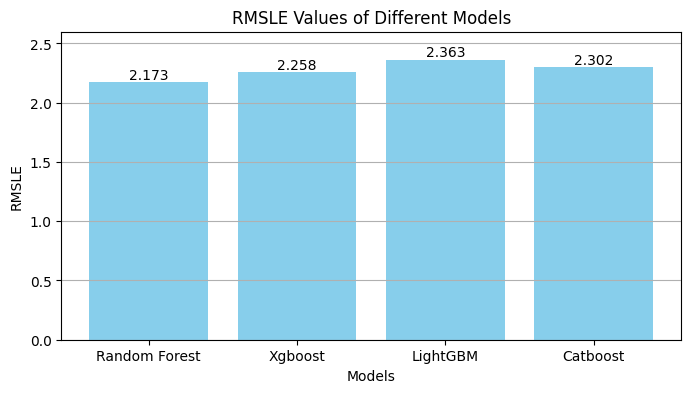

In [391]:
import matplotlib.pyplot as plt

# 模型
models = ['Random Forest', 'Xgboost', 'LightGBM', 'Catboost']

# rmsle
rmsle_values = [2.173, 2.258, 2.363, 2.302]

plt.figure(figsize=(8, 4))
bars = plt.bar(models, rmsle_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('RMSLE')
plt.title('RMSLE Values of Different Models')
plt.ylim(0, max(rmsle_values) * 1.1) 
plt.grid(axis='y')

# 在每个长条的顶部写上数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), va='bottom', ha='center')

plt.show()


### 最終模型訓練

In [392]:
xgb_model.fit(X, y)
rf_model.fit(X, y)
lgb_model.fit(X, y)
cat_model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 1300860, number of used features: 18
[LightGBM] [Info] Start training from score 455.482145


## 模型預測

### 讀取資料

In [393]:
test_df = pd.read_csv("test.csv")
holiday_event_df = pd.read_csv("holidays_events.csv")
stores_df = pd.read_csv("stores.csv")
# transaction_df = pd.read_csv("testing_transactions.csv")
oil_df = pd.read_csv("oil.csv")

### 合併資料

In [394]:
test_df['date'] = pd.to_datetime(test_df['date'])
holiday_event_df['date'] = pd.to_datetime(holiday_event_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
transaction_df['date'] = pd.to_datetime(transaction_df['date'])

In [395]:
test_df = pd.merge(test_df, oil_df, on='date', how='left')
test_df = pd.merge(test_df, stores_df, on='store_nbr', how='left')
test_df = pd.merge(test_df, transaction_df, on=['date', 'store_nbr'], how='left')

In [396]:
# holiday_event_df如果是National的資料就按照date合併；是其他的資料就按照date、city合併
test_national_df = pd.merge(test_df, national_df, on='date', how='left')
test_non_national_df = pd.merge(test_df, non_national_df, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
test_df = test_national_df.combine_first(test_non_national_df)

欄位名稱轉換（因為原始資料集有兩個type欄位分別在holiday_event_df跟stores_df）

In [397]:
test_df = test_df.rename(columns={'type_x': 'store_type', 'type_y': 'event_type'})

### 特徵工程
1. 日期欄位拆分
2. 數值欄位 min-max normalization
3. 類別欄位做 one hot encoding

In [398]:
# 日期欄位拆分
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek

In [399]:
# 數值欄位 min-max normalization
columns_to_normalize = ['onpromotion', 'dcoilwtico', 'transactions']
test_df[columns_to_normalize] = (test_df[columns_to_normalize] - test_df[columns_to_normalize].min()) / (test_df[columns_to_normalize].max() - test_df[columns_to_normalize].min())

新增經緯度欄位

In [400]:
cities_coordinates = {
    "Quito": {"lat": -0.1806532, "lon": -78.4678382},
    "Guayaquil": {"lat": -2.1709979, "lon": -79.9223592},
    "Santo Domingo": {"lat": -0.2530494, "lon": -79.1753765},
    "Cuenca": {"lat": -2.9001285, "lon": -79.0058965},
    "Latacunga": {"lat": -0.9393387, "lon": -78.6155545},
    "Manta": {"lat": -0.9676533, "lon": -80.7089101},
    "Machala": {"lat": -3.2581112, "lon": -79.9553924},
    "Ambato": {"lat": -1.2416666, "lon": -78.6195459},
    "Quevedo": {"lat": -1.0225124, "lon": -79.4604035},
    "Esmeraldas": {"lat": 0.9681789, "lon": -79.6517202},
    "Loja": {"lat": -3.9931283, "lon": -79.2042216},
    "Libertad": {"lat": -2.2311612, "lon": -80.9008852},
    "Playas": {"lat": -2.6284683, "lon": -80.3895886},
    "Daule": {"lat": -1.8621807, "lon": -79.9776688},
    "Babahoyo": {"lat": -1.8019264, "lon": -79.5346458},
    "Cayambe": {"lat": 0.0430556, "lon": -78.1459943},
    "Salinas": {"lat": -2.2171001, "lon": -80.9586051},
    "Puyo": {"lat": -1.4923925, "lon": -78.0024134},
    "Guaranda": {"lat": -1.5904732, "lon": -79.0022925},
    "Ibarra": {"lat": 0.3517083, "lon": -78.1223373},
    "Riobamba": {"lat": -1.6635508, "lon": -78.654646},
    "El Carmen": {"lat": -0.2687816, "lon": -79.466199}
}

test_df['coordinates'] = test_df['city'].map(cities_coordinates)

test_df['longitude'] = test_df['coordinates'].map(lambda x: x['lon'] if x is not None else None)
test_df['latitude'] = test_df['coordinates'].map(lambda x: x['lat'] if x is not None else None)

test_df.drop('coordinates', axis=1, inplace=True)

處理假期與活動資訊

In [401]:
test_df['isHoliday'] = test_df.apply(replace_transfer, axis=1)
test_df['isEvent'] = test_df.apply(isEvent, axis=1)
test_df['isHoliday'] = test_df['isHoliday'].astype(bool)

one hot encoding

In [402]:
test_df = pd.get_dummies(test_df, columns=['store_type'])

刪除不必要的欄位

In [403]:
t_df = test_df.drop(columns=['family', 'description', 'date', 'event_type', 'city', 'state','locale_name','transferred','locale'])  
t_df

,id,store_nbr,onpromotion,dcoilwtico,cluster,transactions,year,month,day,day_of_week,longitude,latitude,isHoliday,isEvent,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
0,3000888,1,0.000000,0.319392,13,NaN,2017,8,16,2,-78.467838,-0.180653,False,0,False,False,False,True,False
1,3000889,1,0.000000,0.319392,13,NaN,2017,8,16,2,-78.467838,-0.180653,False,0,False,False,False,True,False
2,3000890,1,0.003096,0.319392,13,NaN,2017,8,16,2,-78.467838,-0.180653,False,0,False,False,False,True,False
3,3000891,1,0.030960,0.319392,13,NaN,2017,8,16,2,-78.467838,-0.180653,False,0,False,False,False,True,False
4,3000892,1,0.000000,0.319392,13,NaN,2017,8,16,2,-78.467838,-0.180653,False,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,0.001548,0.494297,6,NaN,2017,8,31,3,-78.467838,-0.180653,False,0,False,True,False,False,False
28508,3029396,9,0.000000,0.494297,6,NaN,2017,8,31,3,-78.467838,-0.180653,False,0,False,True,False,False,False
28509,3029397,9,0.001548,0.494297,6,NaN,2017,8,31,3,-78.467838,-0.180653,False,0,False,True,False,False,False
28510,3029398,9,0.013932,0.494297,6,NaN,2017,8,31,3,-78.467838,-0.180653,False,0,False,True,False,False,False


### 預測

In [404]:
# predict
X_test = t_df.drop(['id'], axis=1)
y_pred = xgb_model.predict(X_test)


submission_xgb = pd.DataFrame({
    "id": t_df["id"],
    "sales": y_pred
})

submission_xgb.to_csv("submission_xgb.csv", index=False)

In [405]:
# predict
y_pred = rf_model.predict(X_test)

submission_rf = pd.DataFrame({
    "id": t_df["id"],
    "sales": y_pred
})

submission_rf.to_csv("submission_rf.csv", index=False)

In [406]:
# predict
y_pred = lgb_model.predict(X_test)

submission_lgb = pd.DataFrame({
    "id": t_df["id"],
    "sales": y_pred
})

submission_lgb.to_csv("submission_lgb.csv", index=False)

In [407]:
# predict
y_pred = cat_model.predict(X_test)

submission_cat = pd.DataFrame({
    "id": t_df["id"],
    "sales": y_pred
})

submission_cat.to_csv("submission_cat.csv", index=False)